# Project 7: Statistical Analysis and Hypothesis Testing

# About the Project

 The project involves working on data related to Cookie Cats – a hugely popular puzzle game. As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged. But where should the gates be placed and how the placement of the gates can retain the players for more time.


# Packages and setup

In [87]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
from scipy.stats import levene 
import scipy.stats as stats

In [71]:
#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading data and initial processing

In [72]:
#importing the dataset
user_df=pd.read_csv('cookie_cats.csv')

In [73]:
#Checking the data types of each column
user_df.shape

(90189, 5)

In [74]:
#Displaying the first 10 rows of the dataset
user_df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


# Exercise

# Q1. Detect and resolve problems in the data (Missing value, Outliers, etc.)

# Q1.1 Identify missing value

In [75]:
#Check for any missing values in the data using isnull() function
null_columns= user_df.isnull().sum()
null_columns

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

# Q1.2 Identify outliers

Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

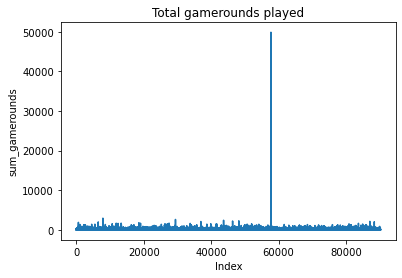

In [76]:
#Check for outlier values in sum_gamerounds column
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

In [77]:
#Based on the plot, filter out the outlier from sum_gamerounds played; Use max() fucntion to find the index of the outlier
print("max values of sum_gamerounds")
max_value=max(user_df.sum_gamerounds)
max_value

print("index of the max value")
index_value=user_df[user_df.sum_gamerounds.isin([max_value])].index.tolist()
index_value

#remove the row by index
user_df.drop(user_df.index[index_value],inplace=True)




max values of sum_gamerounds


49854

index of the max value


[57702]

Text(0.5, 1.0, 'Total gamerounds played')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'sum_gamerounds')

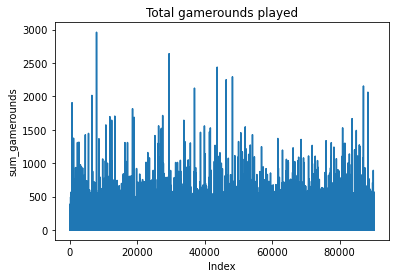

In [78]:
#Plot the graph for sum_gamerounds player after removing the outlier
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds")
plt.plot(user_df.sum_gamerounds)

# Q2. Plot summary statistics and identify trends to answer basis business questions

# Q2.1 What is the overall 7-day retention rate of the game?

In [79]:
#Insert calculation for 7-day retention rate
retention_rate_7= round(user_df.retention_7.sum()/user_df.shape[0]*100,2)
print("Overal 7 days retention rate of the game for both versions is: " ,retention_rate_7,"%")
                        

Overal 7 days retention rate of the game for both versions is:  18.61 %


# Q2.2 How many players never played the game after installing?

In [80]:
user_df[user_df.sum_gamerounds==0].shape[0]

3994

# Q2.3 Does the number of users decrease as the level progresses highlighting the difficulty of the game?

Text(0.5, 1.0, 'Count of players vs sum_gamerounds')

Text(0.5, 0, 'sum_gamerounds')

Text(0, 0.5, 'Count of players')

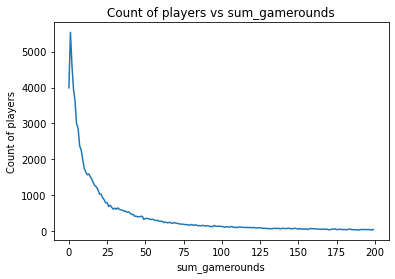

In [81]:
#Group by sum_gamerounds and count the number of users for the first 200 gamerounds
new_data= user_df[["userid","sum_gamerounds"]].groupby("sum_gamerounds").count().reset_index().rename(columns={"userid" : "count"})[0:200]

#Use plot() function on the summarized stats to visualize the chart
plt.title("Count of players vs sum_gamerounds")
plt.xlabel("sum_gamerounds")
plt.ylabel("Count of players")
plt.plot(new_data["sum_gamerounds"],new_data["count"])

# Q3. Generate crosstab for two groups of players to understand if there is a difference in 7 days retention rate & total number of game rounds played

# Q3.1 Seven days retention rate summary for different game versions

In [82]:
#Create cross tab for game version and retention_7 flag counting number of users for each possible categories

pd.crosstab(user_df.version, user_df.retention_7).apply(lambda r: r/r.sum(), axis=1)

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


Analysis Result:
    The retention rate for keeping the gate at level 30 is 19% which is more than  the retention rate of keeping the gate at level 30 which is 18.2%

# Q3.2 Gamerounds summary for different game versions

In [83]:
#use pandas group by to calculate average game rounds played summarized by different versions
user_df[["version","sum_gamerounds"]].groupby("version").agg("mean")

,sum_gamerounds
version,
gate_30,51.342111
gate_40,51.298776


Analysis Result: The total number of game rounds played in total by each player do not differ a lot based on different versions of the game

# Q4. Perform two-sample test for groups A and B to test statistical significance amongst the groups in the sum of game rounds played i.e., if groups A and B are statistically different

# Initial data processing

In [84]:
#Define A/B groups for hypothesis testing
#user_df["version"] = np.where(user_df.version == "gate_30", "A", "B")
user_df["version"] = user_df["version"].replace(["gate_30","gate_40"],["A","B"])
group_A=pd.DataFrame(user_df[user_df.version=="A"]["sum_gamerounds"])
group_B=pd.DataFrame(user_df[user_df.version=="B"]["sum_gamerounds"])


# Q4.1 Shapiro test of Normality

In [85]:
#---------------------- Shapiro Test ----------------------
# NULL Hypothesis H0: Distribution is normal
# ALTERNATE Hypothesis H1: Distribution is not normal    

#test for group_A
shapiro(group_A)

#test for group_B
shapiro(group_B)

ShapiroResult(statistic=0.48864424228668213, pvalue=0.0)

ShapiroResult(statistic=0.48256540298461914, pvalue=0.0)

Analysis Result:
    The two groups are not distributed Normally

# Q4.2 Test of homegeneity of variance

In [89]:
#---------------------- Leven's Test ----------------------
# NULL Hypothesis H0: Two groups have equal variances
# ALTERNATE Hypothesis H1: Two groups do not have equal variances

#perform levene's test and accept or reject the null hypothesis based on the results
levene(group_A.sum_gamerounds,group_B.sum_gamerounds)

LeveneResult(statistic=0.07510153837481241, pvalue=0.7840494387892463)

Analysis Result:
    As per the p-value,null hypothesis is accepted.The two groups have equal variances

# Q4.3 Test of significance: Two sample test

In [90]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: Two samples are different

#Apply relevant two sample test to accept or reject the NULL hypothesis
stats.mannwhitneyu(group_A.sum_gamerounds,group_B.sum_gamerounds)

MannwhitneyuResult(statistic=1009027049.5, pvalue=0.02544577639572688)

In [91]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: Two samples are different

#Apply relevant two sample test to accept or reject the NULL hypothesis
stats.mannwhitneyu(group_A.sum_gamerounds,group_B.sum_gamerounds,alternative="greater")

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.02544577639572688)

Analysis Result:
    Users at gate_30 have played more games than the users at gate_40 
    

# Q5. Based on significance testing results, if groups A and B are statistically different, which level has more advantage in terms of player retention and number of game rounds played

In [93]:
#Analyze the 1 day and 7 days retention rate for two different groups using group by function
user_df[["version","retention_7","retention_1"]].groupby("version").agg("mean")

,retention_7,retention_1
version,,
A,0.190183,0.448198
B,0.182000,0.442283


Analysis Result:
    The CEO of the company must choose gate level 30 since it has a higher retention rate as compared to the gate at level 40